# **PROJECT OBJECTIVE: Face detection from training images.**

In [ ]:
%tensorflow_version 2.x
import tensorflow
tensorflow.__version__

# Initialize the random number generator
import random
random.seed(0)

# Ignore the warnings
import warnings
warnings.filterwarnings("ignore")


In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


## **Step 1: Import the dataset.**

In [ ]:
import os
path='/content/drive/MyDrive/DEEP LEARNING 2021/Mod 9-Computer Vision/Project2/part1/'
os. chdir(path)

In [ ]:
import numpy as np
npy = np.load('Part 1- Train data - images.npy',allow_pickle=True)

In [ ]:
npy.shape,npy.size

((409, 2), 818)

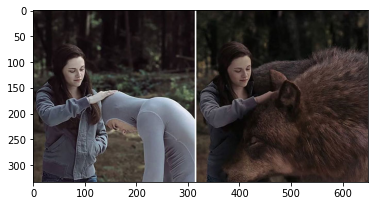

In [ ]:
import cv2
import matplotlib.pyplot as plt
plt.imshow(npy[0][0])


In [ ]:
npy[0][1]

[{'imageHeight': 333,
  'imageWidth': 650,
  'label': ['Face'],
  'notes': '',
  'points': [{'x': 0.08615384615384615, 'y': 0.3063063063063063},
   {'x': 0.1723076923076923, 'y': 0.45345345345345345}]},
 {'imageHeight': 333,
  'imageWidth': 650,
  'label': ['Face'],
  'notes': '',
  'points': [{'x': 0.583076923076923, 'y': 0.2912912912912913},
   {'x': 0.6584615384615384, 'y': 0.46846846846846846}]}]

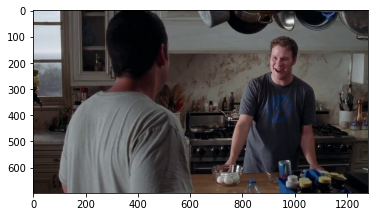

In [ ]:
plt.imshow(npy[1][0])

In [ ]:
npy[1][1]

[{'imageHeight': 697,
  'imageWidth': 1280,
  'label': ['Face'],
  'notes': '',
  'points': [{'x': 0.7053087757313109, 'y': 0.23260437375745527},
   {'x': 0.7692307692307693, 'y': 0.36182902584493043}]}]

## **Step 2: Create features (images) and labels (mask) using that data**

In [ ]:
import cv2
from tensorflow.keras.applications.mobilenet import preprocess_input
import matplotlib.pyplot as plt

In [ ]:
masks=np.zeros((int(npy.shape[0]),224,224))
print(masks.shape)
X=np.zeros((int(npy.shape[0]),224,224,3))
print(X.shape)


(409, 224, 224)
(409, 224, 224, 3)


In [ ]:
for index in range(npy.shape[0]):
  img=npy[index][0]
  img=cv2.resize(img,dsize=(224,224),interpolation=cv2.INTER_CUBIC)

  X[index]=preprocess_input(np.array(img, dtype=np.float32))


  for i in npy[index][1]:
    x1=int(i['points'][0]['x']*224) # * image_width
    x2=int(i['points'][1]['x']*224) # * image_width
    y1=int(i['points'][0]['y']*224) # * image_height
    y2=int(i['points'][1]['y']*224) # * image_height
    masks[index][y1:y2,x1:x2]=1
  

In [ ]:
X_train=X[:300]
X_val=X[300:]
y_train=masks[:300]
y_val=masks[300:]

In [ ]:
print(X_train.shape,y_train.shape)
print(X_val.shape,y_val.shape)

(300, 224, 224, 3) (300, 224, 224)
(97, 224, 224, 3) (97, 224, 224)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


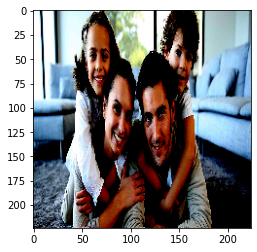

In [ ]:
plt.imshow(X[11])

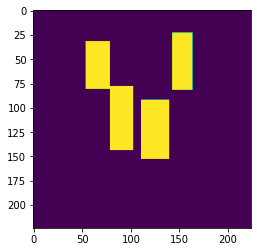

In [ ]:
plt.imshow(masks[11])

# **Plot the images**

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


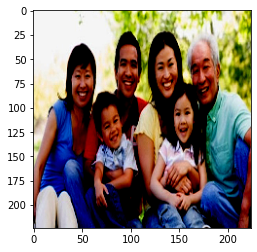

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(X[2])

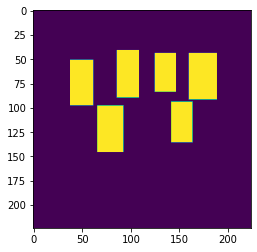

In [ ]:
plt.imshow(masks[2])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


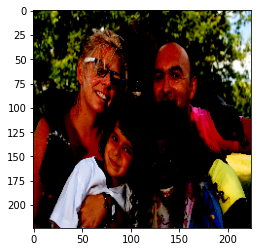

In [ ]:
plt.imshow(X[201])

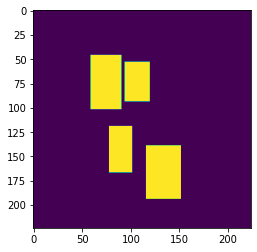

In [ ]:
plt.imshow(masks[201])

# **Step 3: Mask detection model**

## **Step 3.1 :Design a face mask detection model**


**We are using U-Net along with MobileNet as pre-trained transfer learning model.**

In [ ]:
from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, Reshape,UpSampling2D,Concatenate

ALPHA = 1.0 
def create_model(trainable=True):
    model = MobileNet(input_shape=(224, 224, 3), include_top=False, alpha=ALPHA) 

    for layer in model.layers:
        layer.trainable = trainable

    block0=model.get_layer('conv_pw_1_relu').output
    block1=model.get_layer('conv_pw_3_relu').output 
    block2=model.get_layer('conv_pw_5_relu').output 
    block3=model.get_layer('conv_pw_11_relu').output 
    block4=model.get_layer('conv_pw_13_relu').output 

    x=Concatenate()([UpSampling2D()(block4),block3])
    #print(x.shape) 
    x=Concatenate()([UpSampling2D()(x),block2])
    #print(x.shape) 
    x=Concatenate()([UpSampling2D()(x),block1])
    #print(x.shape) 
    x=Concatenate()([UpSampling2D()(x),block0])
    #print(x.shape)
    x=UpSampling2D()(x)
    #print(x.shape)

    x = Conv2D(1, kernel_size=1, name="coords",activation='sigmoid')(x)
    #print(x.shape)
    x = Reshape((224,224))(x) 
    #print(x.shape)

    return Model(inputs=model.input, outputs=x)

In [ ]:
model = create_model(False)

17227776/17225924 [==============================] - 0s 0us/step


In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 32) 128         conv1[0][0]                      
__________________________________________________________________________________________________
conv1_relu (ReLU)               (None, 112, 112, 32) 0           conv1_bn[0][0]                   
______________________________________________________________________________________________

## **Step 3.2 : Design your own Dice Coefficient and Loss function.**

In [ ]:
def dice_coefficient(y_true, y_pred):
    numerator = 2 * tensorflow.reduce_sum(y_true * y_pred)
    denominator = tensorflow.reduce_sum(y_true + y_pred)

    return numerator / (denominator + tensorflow.keras.backend.epsilon())

In [ ]:
def loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) - tensorflow.keras.backend.log(dice_coefficient(y_true, y_pred) + tensorflow.keras.backend.epsilon())

## **Step 3.4 : Train, tune and test the model.**

In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import binary_crossentropy

optimizer = Adam(lr=1e-4, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model.compile(loss=loss, optimizer=optimizer, metrics=[dice_coefficient])

In [ ]:
# Fit the model
model.fit(X_train, y_train, validation_data = (X_val, y_val), epochs=10, batch_size=10)


Epoch 1/10
40/40 [==============================] - 47s 329ms/step - loss: 2.1113 - dice_coefficient: 0.2200 - val_loss: 1.8267 - val_dice_coefficient: 0.2593
Epoch 2/10
40/40 [==============================] - 12s 303ms/step - loss: 1.6755 - dice_coefficient: 0.2906 - val_loss: 1.5047 - val_dice_coefficient: 0.3233
Epoch 3/10
40/40 [==============================] - 12s 304ms/step - loss: 1.4188 - dice_coefficient: 0.3495 - val_loss: 1.2993 - val_dice_coefficient: 0.3777
Epoch 4/10
40/40 [==============================] - 12s 304ms/step - loss: 1.2355 - dice_coefficient: 0.4011 - val_loss: 1.1660 - val_dice_coefficient: 0.4216
Epoch 5/10
40/40 [==============================] - 12s 306ms/step - loss: 1.1383 - dice_coefficient: 0.4341 - val_loss: 1.0746 - val_dice_coefficient: 0.4539
Epoch 6/10
40/40 [==============================] - 12s 306ms/step - loss: 1.0608 - dice_coefficient: 0.4597 - val_loss: 1.0081 - val_dice_coefficient: 0.4795
Epoch 7/10
40/40 [============================

## **Step 3.5 :Evaluate the model using testing data.**

There is no separate testing data given to us. So, earlier we had divided the given dataset into training set and validation set.

In [ ]:
model.evaluate(X_train,y_train)
model.evaluate(X_val,y_val)

Getting **Resource Exhausted Error** when executing model.evaluate( ) on both Training and Validation Data.

From earlier code, we see the model has **Training Loss= 0.89, Training Dice Coefficient=0.53 , Validation Loss=0.86 , Validation Dice Coefficient=0.54**

## **Step 4: Use the “Prediction image” as an input to your designed model and display the output of the image**

In [ ]:
filename = '/content/drive/MyDrive/Mod 9-Computer Vision/Project2/part1/Part 1Test Data - Prediction Image.jpeg'
img = cv2.imread(filename) # Original image for display

In [ ]:
img.shape

(500, 500, 3)

In [ ]:
img=cv2.resize(img,dsize=(224,224),interpolation=cv2.INTER_CUBIC)
img.shape

(224, 224, 3)

In [ ]:
  X_test=preprocess_input(np.array(img, dtype=np.float32))
  X_test.shape

(224, 224, 3)

In [ ]:
mask_test=model.predict(X_test)

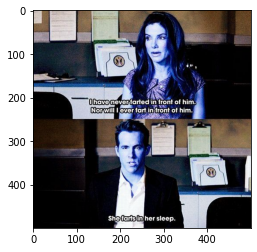

In [ ]:
plt.imshow(img)

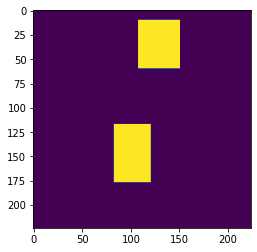

In [ ]:
plt.imshow(masks_test)